In [25]:
#THIS IS USED FOR TRAINING ON COMPUTER
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
path_test = 'D:/OneDrive - VietNam National University - HCM INTERNATIONAL UNIVERSITY/Code/CapstoneCode/Data/mitbih_test.csv'
path_train = 'D:/OneDrive - VietNam National University - HCM INTERNATIONAL UNIVERSITY/Code/CapstoneCode/Data/mitbih_train.csv'
mit_test = pd.read_csv(path_test,header=None)
mit_train = pd.read_csv(path_train, header=None)

In [26]:
#Replace columns 187 with Class
mit_test.rename(columns={187:"Class"}, inplace=True)
mit_train.rename(columns={187:"Class"}, inplace=True)

In [27]:
# Setting Dictionary to define the type of Heartbeat
# N: normal
#S: Supraventricular premature beat
#P: Premature ventricular contraction
#F: Fusion of ventricular and normal beat
#U: Unclassifiable beat
MIT_Outcome = {0. : 'N',
               1. : 'S',
               2. : 'P',
               3. : 'F',
               4. : 'U'}

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix,  ConfusionMatrixDisplay
from sklearn.utils import resample

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, InputLayer, LSTM, GRU, BatchNormalization, Bidirectional, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical

In [29]:
#extract class
class_0=mit_train[mit_train["Class"]==0]
class_1=mit_train[mit_train["Class"]==1]
class_2=mit_train[mit_train["Class"]==2]
class_3=mit_train[mit_train["Class"]==3]
class_4=mit_train[mit_train["Class"]==4]
#upsampling and equalize the number of sample for each class
#class_0_upsample=resample(class_0,replace=True,n_samples=80000,random_state=123)
#class_1_upsample=resample(class_1,replace=True,n_samples=150000,random_state=123)
#class_2_upsample=resample(class_2,replace=True,n_samples=90000,random_state=124)
#class_3_upsample=resample(class_3,replace=True,n_samples=120000,random_state=125)
#class_4_upsample=resample(class_4,replace=True,n_samples=80000,random_state=126)
class_0_upsample=class_0
class_1_upsample=resample(class_1,replace=True,n_samples=7000,random_state=123)
class_2_upsample=resample(class_2,replace=True,n_samples=8000,random_state=124)
class_3_upsample=resample(class_3,replace=True,n_samples=10000,random_state=125)
class_4_upsample=resample(class_4,replace=True,n_samples=8000,random_state=126)

#combine
mit_train=pd.concat([class_0_upsample,class_1_upsample,class_2_upsample,class_3_upsample,class_4_upsample])
print(mit_train.shape)
print(mit_train["Class"].value_counts())

(105471, 188)
0.0    72471
3.0    10000
2.0     8000
4.0     8000
1.0     7000
Name: Class, dtype: int64


In [30]:
#Split train data into train and valid data
train, valid, out_train, out_valid = train_test_split(mit_train.iloc[:,:187], mit_train["Class"], train_size = 0.8, random_state=42)
test, out_test = mit_test.iloc[:,:187], mit_test["Class"]

#Normalize the data
train = normalize(train, axis = 0, norm='max')
test = normalize(test, axis = 0, norm='max')
valid = normalize(valid, axis = 0, norm='max')

#Change 2D (mxn) data into 3D data (mxnx1)
x_train = train.reshape(train.shape[0],train.shape[1],1)
x_test = test.reshape(test.shape[0],test.shape[1],1)
x_valid = valid.reshape(valid.shape[0],valid.shape[1],1)

#Categorize the target
y_train = to_categorical(out_train)
y_test = to_categorical(out_test)
y_valid = to_categorical(out_valid)

In [31]:
from keras.layers import Dense,Flatten,Conv1D,Activation,Dropout,Input,BatchNormalization, SeparableConv1D
from keras.layers import GlobalMaxPooling1D, Input
from keras import backend as K
from keras import layers
from keras.models import Sequential, Model
from keras.models import load_model
from keras.layers import MaxPooling1D

In [32]:
def VGG19():
    model = Sequential()
    model.add(Conv1D(input_shape=(187,1),filters=64,kernel_size=3,padding="same", activation="relu"))
    model.add(Conv1D(filters=64,kernel_size=3,padding="same"))
    model.add(MaxPooling1D(pool_size=6,strides=2))
    model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=6,strides=2))
    model.add(Activation("relu"))
    model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=6,strides=2))
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=6,strides=2))
    model.add(Activation("relu"))
    model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=6,strides=2))
    model.add(Conv1D(filters=64, kernel_size=3, padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(0.2))
    model.add(Flatten(name='flatten'))
    model.add(Dense(128, name='fc1'))
    model.add(Activation("relu"))
    model.add(Dense(128, name='fc2'))
    model.add(Activation("relu"))
    # model.add(Dense(64, activation='relu', name='fc3'))
    model.add(Dense(5 , activation = 'softmax', name='output'))
    return model


In [33]:
model_khanh= VGG19()
model_khanh.summary()
checkpoint_cb = ModelCheckpoint("CVDs_khanh1.h5", save_best_only=True)
model_khanh.compile(optimizer="adam", loss="categorical_crossentropy", metrics=[tfa.metrics.F1Score(2,"micro")])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_54 (Conv1D)          (None, 187, 64)           256       
                                                                 
 conv1d_55 (Conv1D)          (None, 187, 64)           12352     
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, 91, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_56 (Conv1D)          (None, 91, 64)            12352     
                                                                 
 batch_normalization_44 (Bat  (None, 91, 64)           256       
 chNormalization)                                                
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 43, 64)          

In [34]:
history_khanh = model_khanh.fit(x_train, y_train, epochs=40, batch_size=32, validation_data=(x_valid, y_valid), callbacks=[checkpoint_cb])

Epoch 1/40
2637/2637 [==============================] - 60s 19ms/step - loss: 0.2996 - f1_score: 0.9059 - val_loss: 0.2490 - val_f1_score: 0.9261
Epoch 2/40
2637/2637 [==============================] - 47s 18ms/step - loss: 0.1935 - f1_score: 0.9399 - val_loss: 0.1550 - val_f1_score: 0.9498
Epoch 3/40
2637/2637 [==============================] - 47s 18ms/step - loss: 0.1626 - f1_score: 0.9474 - val_loss: 0.1413 - val_f1_score: 0.9520
Epoch 4/40
2637/2637 [==============================] - 47s 18ms/step - loss: 0.1418 - f1_score: 0.9530 - val_loss: 0.2155 - val_f1_score: 0.9177
Epoch 5/40
2637/2637 [==============================] - 51s 19ms/step - loss: 0.1267 - f1_score: 0.9586 - val_loss: 0.1735 - val_f1_score: 0.9435
Epoch 6/40
2637/2637 [==============================] - 48s 18ms/step - loss: 0.1150 - f1_score: 0.9621 - val_loss: 0.1065 - val_f1_score: 0.9632
Epoch 7/40
2637/2637 [==============================] - 49s 19ms/step - loss: 0.1040 - f1_score: 0.9651 - val_loss: 0.1507 -

In [36]:
model_khanh.load_weights("CVDs_khanh1.h5")
#Evaluate train test valid data
eval_train = model_khanh.evaluate(x_train, y_train)
eval_test = model_khanh.evaluate(x_test, y_test)
eval_valid = model_khanh.evaluate(x_valid, y_valid)

660/660 [==============================] - 4s 6ms/step - loss: 0.0300 - f1_score: 0.9905


In [37]:
#Predict train, test, valid data
pred_train = model_khanh.predict (x_train)
model_pred_train = np.argmax(pred_train,axis=1)

pred_test = model_khanh.predict (x_test)
model_pred_test = np.argmax(pred_test,axis=1)

pred_valid = model_khanh.predict (x_valid)
model_pred_valid = np.argmax(pred_valid,axis=1)

660/660 [==============================] - 3s 5ms/step


In [38]:
print("Predict train outcome")
print(classification_report(out_train, model_pred_train, target_names=[MIT_Outcome[i] for i in MIT_Outcome]))

Predict train outcome
              precision    recall  f1-score   support

           N       1.00      1.00      1.00     57881
           S       0.98      0.99      0.99      5557
           P       1.00      0.98      0.99      6439
           F       0.99      1.00      0.99      8073
           U       1.00      1.00      1.00      6426

    accuracy                           1.00     84376
   macro avg       0.99      0.99      0.99     84376
weighted avg       1.00      1.00      1.00     84376



In [39]:
print("Predict test outcome")
print(classification_report(out_test, model_pred_test, target_names=[MIT_Outcome[i] for i in MIT_Outcome]))


Predict test outcome
              precision    recall  f1-score   support

           N       0.99      0.99      0.99     18118
           S       0.84      0.84      0.84       556
           P       0.98      0.94      0.96      1448
           F       0.73      0.90      0.81       162
           U       1.00      0.98      0.99      1608

    accuracy                           0.99     21892
   macro avg       0.91      0.93      0.92     21892
weighted avg       0.99      0.99      0.99     21892



In [40]:
print("Predict valid outcome")
print(classification_report(out_valid, model_pred_valid, target_names=[MIT_Outcome[i] for i in MIT_Outcome]))


Predict valid outcome
              precision    recall  f1-score   support

           N       1.00      0.99      0.99     14590
           S       0.95      0.98      0.96      1443
           P       0.99      0.97      0.98      1561
           F       0.98      1.00      0.99      1927
           U       1.00      0.99      0.99      1574

    accuracy                           0.99     21095
   macro avg       0.98      0.99      0.98     21095
weighted avg       0.99      0.99      0.99     21095



True positive:  1577
False positive:  2
False negative:  31
True negative:  20282


<Figure size 576x432 with 0 Axes>

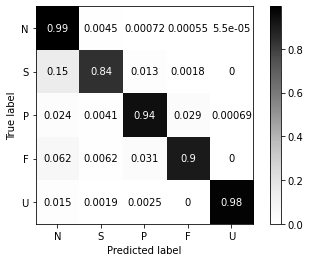

In [41]:
cmm = confusion_matrix(y_true= out_test, y_pred=model_pred_test, labels=list(MIT_Outcome.keys()), normalize = 'true')
cm = confusion_matrix(y_true= out_test, y_pred=model_pred_test, labels=list(MIT_Outcome.keys()))
plt.figure(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cmm,display_labels=[MIT_Outcome[i] for i in MIT_Outcome],)
disp.plot(cmap = "Greys")

TruePositive = np.diag(cm)
FalsePositive = []
for i in range(len(MIT_Outcome)):
    FalsePositive.append(sum(cm[:,i]) - cm[i,i])
FalseNegative = []
for i in range(len(MIT_Outcome)):
    FalseNegative.append(sum(cm[i,:]) - cm[i,i])
TrueNegative = []
for i in range(len(MIT_Outcome)):
    temp = np.delete(cm, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TrueNegative.append(sum(sum(temp)))
#l = len(y)
#for i in range(len(MIT_Outcome)):
#    print(TruePositive[i] + FalsePositive[i] + FalseNegative[i] + TrueNegative[i] == l)
print("True positive: ", TruePositive[i])
print("False positive: ", FalsePositive[i])
print("False negative: ", FalseNegative[i])
print("True negative: ", TrueNegative[i])

plt.show()

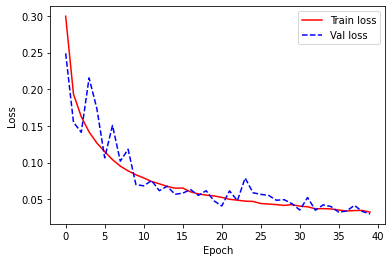

In [42]:
plt.plot(history_khanh.epoch, history_khanh.history['loss'],
           color='r', label='Train loss')
plt.plot(history_khanh.epoch, history_khanh.history['val_loss'],
           color='b', label='Val loss' , linestyle="--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [43]:
import collections
count_predict = collections.Counter(model_pred_test)
model_y_test = np.argmax(y_test, axis = 1)
count_true = collections.Counter(model_y_test)
print(f"Predict = {count_predict}")
print(f"True = {count_true}")

Predict = Counter({0: 18163, 4: 1579, 2: 1393, 1: 558, 3: 199})
True = Counter({0: 18118, 4: 1608, 2: 1448, 1: 556, 3: 162})
